<h2>Feature Engineering</h2>

<h3>Extra Features</h3>

In [24]:
class DiagnosisDateTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        X["Diagnosis_Date"] = X["Age"] - X["N_Days"]
        return X


class AgeYearsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        X["Age_Years"] = round(X["Age"] / 365.25).astype("int16")
        return X

In [33]:
# Pipeline para agreagar features
extra_features_pipeline = Pipeline([
    ("diagnosis_date", DiagnosisDateTransformer()),
    ("age_years", AgeYearsTransformer()),
])

df_train_mod = extra_features_pipeline.fit_transform(df_train)
df_test_mod = extra_features_pipeline.fit_transform(df_train)

df_train_mod.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,...,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,Diagnosis_Date,Age_Years
0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,...,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D,20533,59
1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,...,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C,16663,53
2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,...,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D,10299,38
3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,...,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C,15884,51
4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,...,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C,15870,46


In [26]:
# Actualizar features
_, CAT_FEATURES, NUM_FEATURES = split_features(df_train_mod, TARGET)

<h3>Feature Encoding - Pipeline</h3>

Después de analizar nuestros features categóricos, podemos sacar las siguientes conclusiones:

- Las features Drug, Sex, Ascites, Hepatomegaly, Spiders al ser categóricas podemos aplicarles un Binary-Encoding.
- Stage indica las distintas etapas de la condición del paciente, es decir, posee un orden específico. Por lo tanto, sería adecuado utilizar Ordinal-Encoding.
- Dado que State es nuestra variable objetivo, podemos aplicar un Label-Encoding.

In [27]:
one_hot_encoder = ColumnTransformer([
    (
        'one_hot_encoder',
        OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
        ["Edema"]
    )
])

In [28]:
ordinal_encoder = ColumnTransformer([
    (
        'ordinal_encoder',
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        [
            "Drug",
            "Sex",
            "Ascites",
            "Hepatomegaly",
            "Spiders",
            "Stage"
        ]
    )
])

In [29]:
passthrough = ColumnTransformer([
    (
        "passthrough",
        "passthrough",
        NUM_FEATURES
    )
])

In [30]:
feature_engineering_pipeline = Pipeline(
    [
        (
            "features",
            FeatureUnion(
                [
                    ("ohe", one_hot_encoder),
                    ("ordinal", ordinal_encoder),
                    ("pass", passthrough),
                ]
            ),
        )
    ]
)

In [31]:
transformed = feature_engineering_pipeline.fit_transform(df_train)
transformed.shape

(7905, 23)

<h2>Split data (train, valid)</h2>

In [25]:
label_encoder = LabelEncoder()

X = df_train_mod.drop(["Status"], axis = 1)
y = label_encoder.fit_transform(df_train_mod["Status"])
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

print("Longitud de X_train:", len(X_train))
print("Longitud de X_valid:", len(X_valid))

Longitud de X_train: 6324
Longitud de X_valid: 1581


<h2>Model Training</h2>

In [26]:
feature_transformer = clone(feature_engineering_pipeline)

features_train_x = feature_transformer.fit_transform(X_train)
features_validate_x = feature_transformer.transform(X_valid)

In [27]:
model = RandomForestClassifier(n_estimators=100)
model.fit(features_train_x, y_train)

RandomForestClassifier()

<h2>Model Validation</h2>

In [28]:
pred_y = model.predict(features_validate_x)
acc_score = accuracy_score(y_valid, pred_y)

print("Accuracy score:", acc_score)

Accuracy score: 0.8349146110056926


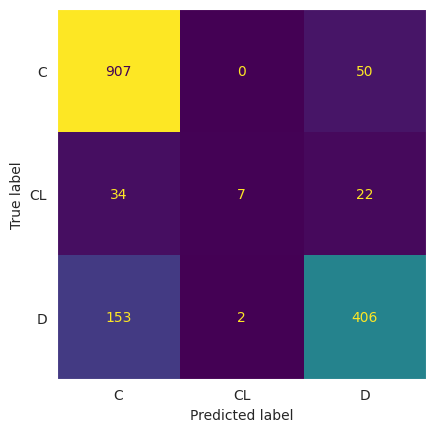

In [29]:
# Confusion Matrix

ConfusionMatrixDisplay.from_predictions(y_valid, pred_y, display_labels=label_encoder.classes_, colorbar=False)
plt.grid(False)
plt.show()